In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from IPython.display import clear_output

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split
from copy import deepcopy

In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
# warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/plasticc/good_objects.csv.gz')

data = data[data.detected_bool == 1]

In [6]:
data.head()

,good_objects.csv,object_id,mjd,passband,flux,flux_err,detected_bool,log_lam,class
0,924.0,730.0,60532.3019,2.0,20.994711,1.047298,1.0,3.790512,0.0
1,926.0,730.0,60532.3173,3.0,31.523088,1.569497,1.0,3.875155,0.0
2,927.0,730.0,60532.3282,4.0,41.159981,2.310168,1.0,3.938479,0.0
3,928.0,730.0,60532.3392,5.0,46.795868,5.458707,1.0,3.987288,0.0
4,931.0,730.0,60535.2957,3.0,30.361010,2.107024,1.0,3.875155,0.0


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Utils

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id].copy()
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject.loc[:, 'log_lam'] = log_lam
    return anobject

In [12]:
def is_good(anobject):
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 7:
            count += 1
    if count > 3:
        return 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return 0
    
    return 1

# Visualization

In [13]:
def plot_light_curves(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 5))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        if is_plot:
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values*10**(-4.44), linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values*10**(-4.44), label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux [mJy]', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

In [14]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 5.5))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux [mJy]', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

13.0


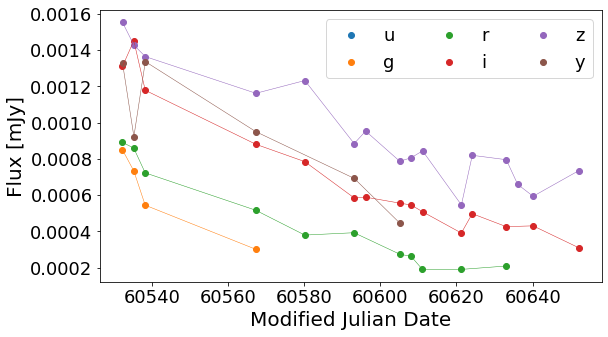

88.0


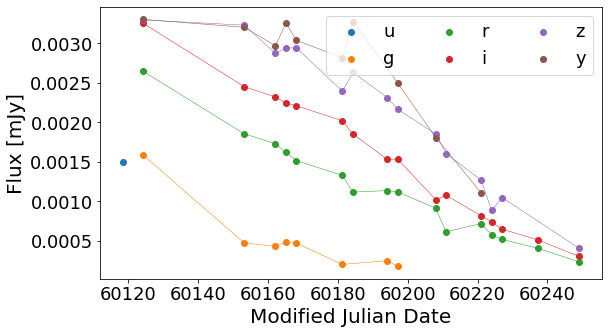

96.0


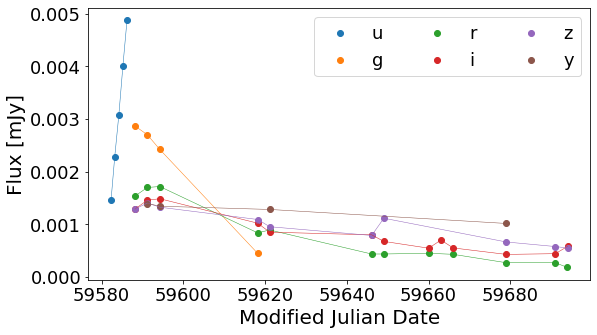

176.0


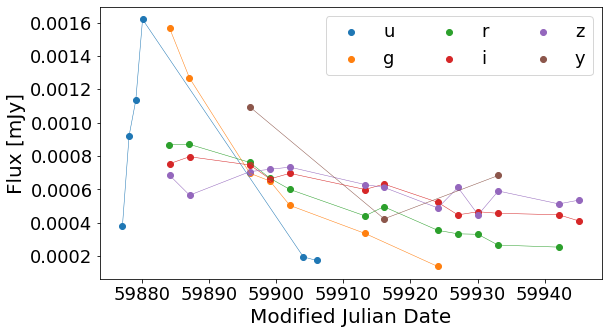

195.0


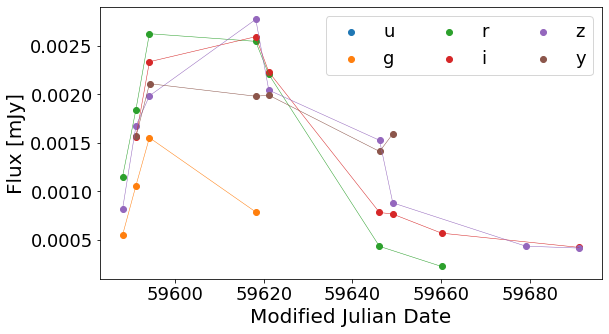

198.0


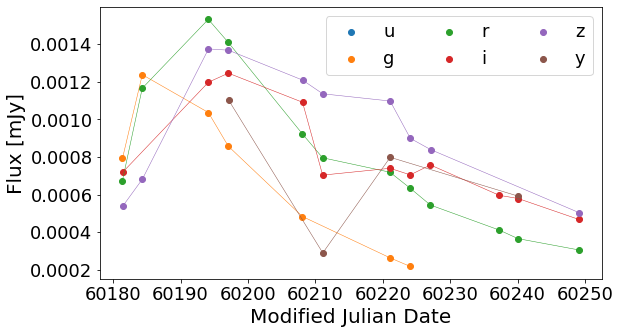

In [15]:
for i in object_ids[:20]:
    anobject = get_object(data, i)
    if not is_good(anobject):
        continue
    print(i)
    plot_light_curves(anobject)
    plt.show()

# One object test Test

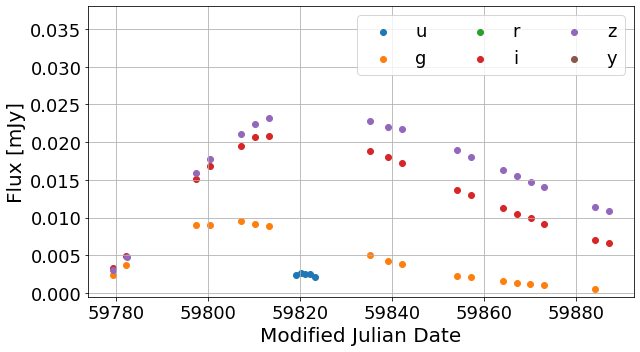

In [16]:
anobject = get_object(data, 34299) # 34299, 329277
anobject = add_log_lam(anobject)
anobject['flux'] += 1*np.random.normal(0, anobject['flux_err'], len(anobject))
#anobject['flux'] *= 10**(-4.44)

anobject = anobject[(anobject.passband != 2)*(anobject.passband != 5)]
#anobject = anobject[(anobject.passband == 2)+(anobject.passband == 4)]

plot_light_curves(anobject, is_plot=False)
plt.grid()
plt.ylim(-0.0005, 0.038)
plt.tight_layout()
plt.savefig('img/light_curve_34299_appendix.pdf', format='pdf')
plt.savefig('img/light_curve_34299_appendix.png', format='png')

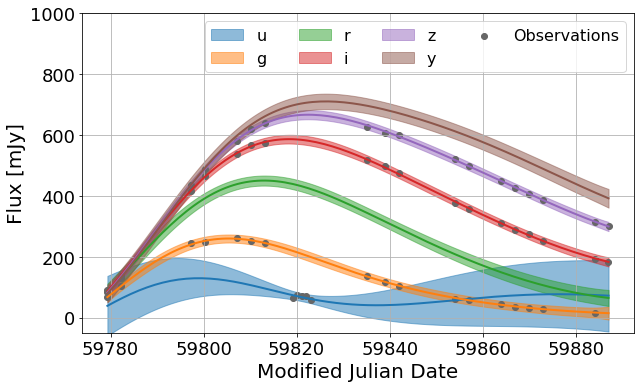

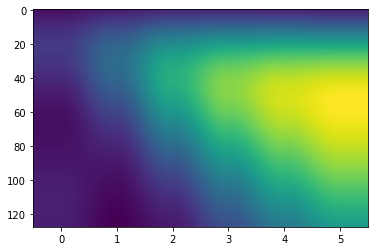

In [17]:
# train test split
t = anobject['mjd'].values
flux = anobject['flux'].values #+ np.random.normal(0, 30, len(t))
flux_err = anobject['flux_err'].values
passband = anobject['passband'].values

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t, flux, flux_err, passband)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=128)

# convert values to 2D-array
data_array = flux_aug.reshape((6, 128))

# add target value for this curve
true_class = int(anobject['class'].to_numpy()[0])


# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, 3*flux_err_aug, passband_aug, title="")
plt.scatter(t, flux, label='Observations', color='0.4')
plt.legend(loc='best', ncol=4, fontsize=16)
plt.ylim(-50, 1000)
plt.grid()
plt.tight_layout()
#plt.savefig('img/light_curve_aug_gp_34299.pdf', format='pdf')
#plt.savefig('img/light_curve_aug_gp_34299.png', format='png')
plt.show()

plt.imshow(data_array.T, aspect='auto')
plt.show()

In [18]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 5))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=3., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+3*flux_err[passband == pb], 
                         flux[passband == pb]-3*flux_err[passband == pb], 
                         label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux [mJy]', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)
    
def plot_points(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    for passband in range(len(passband2name)):
        light_curve = get_passband(anobject, passband)
        plt.scatter(light_curve['mjd'].values, 
                    light_curve['flux'].values*10**(-4.44), s=40)

In [19]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, DotProduct, ConstantKernel as C

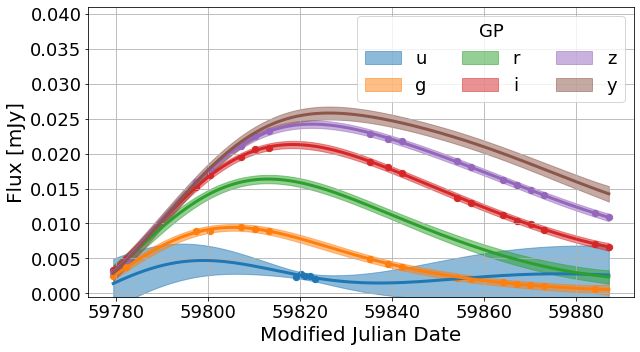

/home/mhushchyn/.conda/envs/astro/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


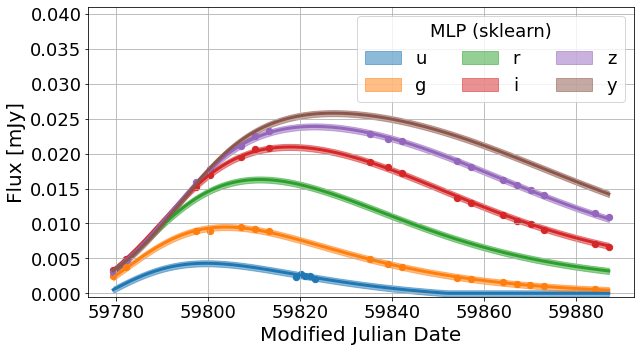

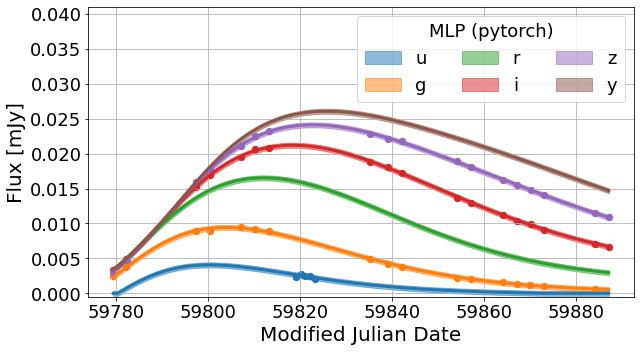

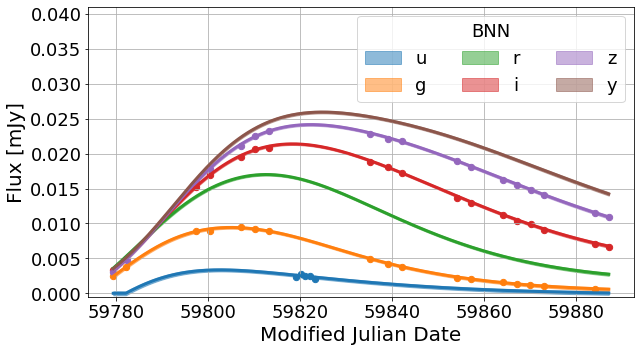

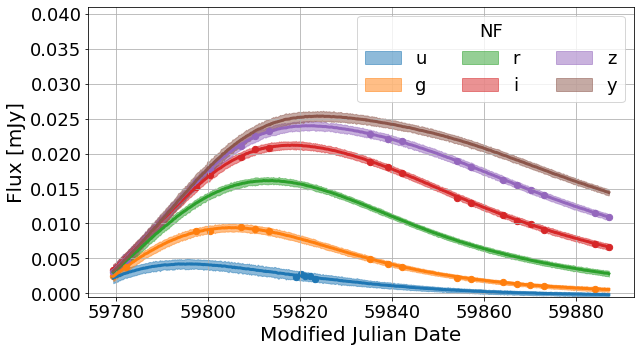

In [20]:
# train test split
t = anobject['mjd'].values
flux = anobject['flux'].values #+ np.random.normal(0, 30, len(t))
flux_err = anobject['flux_err'].values
passband = anobject['passband'].values

for mod in ['GP', 'MLP (sklearn)', 'MLP (pytorch)', 'BNN', 'NF']:
#for mod in ['MLP (sklearn)']:
    # approximation model
    if mod == 'GP':
        #kernel = C(1.0) * Matern([1, 1]) + WhiteKernel()
        #aug = fulu.GaussianProcessesAugmentation(passband2lam, kernel)
        aug = fulu.GaussianProcessesAugmentation(passband2lam)
    elif mod == 'MLP (sklearn)':
        params = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': (20, 10),
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': 0.0003171745,
                              'max_iter': 9000, 
                              'batch_size': 1000, 
                              'weight_decay': 0.03109669}
        aug = fulu.MLPRegressionAugmentation(**params)
    elif mod == 'MLP (pytorch)':
        params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'activation': 'tanh', 
          'n_epochs': 1000, 
          'batch_size': 500, 
          'lr': 0.1, 
          'optimizer': 'Adam', 
          'device': 'auto', 
          'weight_decay': 0.0001}
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif mod == 'BNN':
        params = {'passband2lam': passband2lam, 
                          'n_hidden': 50, 
                          'prior_sigma': 0.1, 
                          'n_epochs': 10000, 
                          'lr': 0.01, 
                          'kl_weight': 0.00001, 
                          'optimizer': 'Adam', 
                          'device': 'cpu', 
                          'weight_decay': 0.00}
        aug = fulu.BayesianNetAugmentation(**params)
    elif mod == 'NF':
        params = {'passband2lam': passband2lam, 
                  'batch_size': 500, 
                  'n_epochs': 10000, 
                  'lr': 0.0100001, 
                  'device': 'cpu', 
                  'weight_decay': 0.01}
        aug = fulu.NormalizingFlowAugmentation(**params)
    
    aug.fit(t, flux, flux_err, passband)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=512)


    # plotting
    plot_light_curves_with_sigma(t_aug, flux_aug*10**(-4.44), flux_err_aug*10**(-4.44), passband_aug, title="")
    plot_points(anobject, title="", is_plot=True)
    #plt.scatter(t, flux, label='Observations', color='0.4', s=10)
    leg = plt.legend(loc='best', ncol=3, fontsize=18, title=mod)
    leg.get_title().set_fontsize('18')
    plt.ylim(-0.0005, 0.041)
    plt.grid()
    plt.tight_layout()
    plt.savefig('img/Plastic_34299_%s_appendix.pdf' % (mod), format='pdf')
    plt.savefig('img/Plastic_34299_%s_appendix.png' % (mod), format='png')
    plt.show()